# Business Problem: Predicting Daily Noon Temperatures for Optimal Energy Management

We are developing a deep learning model to forecast the temperature at 12:00 PM on the next day by analyzing various climatic features from historical weather data. The primary goal of this model is to aid energy management systems in industrial and commercial settings, facilitating proactive adjustments to heating, ventilation, and air conditioning (HVAC) operations. By accurately predicting temperature fluctuations, businesses can optimize their energy usage, resulting in cost savings and improved operational efficiency.

The model leverages an extensive dataset of meteorological variables such as atmospheric pressure, temperature, potential temperature, dew point, relative humidity, vapor pressure, specific humidity, water vapor concentration, air density, wind velocity, and wind direction. This data-driven approach allows the model to capture complex patterns and dependencies, enabling precise temperature forecasts.

# IMPORTING THE LIBRARIES 

In [29]:
import os
from zipfile import ZipFile
import numpy as np
import pandas as pd
import sklearn.metrics
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import tensorflow as tf
import keras
import plotly.graph_objects as go
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input,Flatten, Dense, Dropout, BatchNormalization, Conv2D, MaxPooling2D, LeakyReLU, LSTM
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import random

In [44]:
np.random.seed(42)
tf.random.set_seed(42)

# DATA COLLECTION

In [45]:
uri = "https://storage.googleapis.com/tensorflow/tf-keras-datasets/jena_climate_2009_2016.csv.zip"
zip_path = keras.utils.get_file(origin=uri, fname="jena_climate_2009_2016.csv.zip")
zip_file = ZipFile(zip_path)
zip_file.extractall()
csv_path = "jena_climate_2009_2016.csv"

df = pd.read_csv(csv_path)
display(df.head())

,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
0,01.01.2009 00:10:00,996.52,-8.02,265.40,-8.90,93.3,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.3
1,01.01.2009 00:20:00,996.57,-8.41,265.01,-9.28,93.4,3.23,3.02,0.21,1.89,3.03,1309.80,0.72,1.50,136.1
2,01.01.2009 00:30:00,996.53,-8.51,264.91,-9.31,93.9,3.21,3.01,0.20,1.88,3.02,1310.24,0.19,0.63,171.6
3,01.01.2009 00:40:00,996.51,-8.31,265.12,-9.07,94.2,3.26,3.07,0.19,1.92,3.08,1309.19,0.34,0.50,198.0
4,01.01.2009 00:50:00,996.51,-8.27,265.15,-9.04,94.1,3.27,3.08,0.19,1.92,3.09,1309.00,0.32,0.63,214.3


# DATA PREPROCESSING

In [46]:
df[["Date", "Time"]] = df["Date Time"].str.split(" ", expand =True)
df = df.drop("Date Time", axis=1)
df = df[df["Time"] == "12:00:00"]
df = df.drop("Time", axis=1)
df = df.set_index("Date")
df.head()

,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
Date,,,,,,,,,,,,,,
01.01.2009,1000.30,-6.87,266.27,-8.28,89.6,3.64,3.27,0.38,2.03,3.26,1306.98,1.84,2.63,184.40
02.01.2009,998.91,-3.12,270.13,-4.50,90.1,4.85,4.37,0.48,2.73,4.38,1286.47,1.54,2.00,127.00
03.01.2009,999.02,-5.96,267.28,-8.72,80.7,3.91,3.16,0.75,1.97,3.16,1300.90,1.31,1.88,213.90
04.01.2009,988.94,-1.21,272.82,-2.36,91.8,5.59,5.13,0.46,3.23,5.19,1264.30,1.99,3.88,225.80
05.01.2009,990.42,-3.65,270.26,-5.54,86.6,4.66,4.04,0.62,2.54,4.08,1278.21,5.49,8.38,17.44


1. I split the **Date Time** column into separate **Date** and **Time** columns using **str.split** method by setting **expand** = **True**.

2. I drop Date Time column from my dataframe **df** since I splitted the column.

3. Assumptions are made here inorder to have simpler model I am consider one particular time that is **12 o'clock**. So that I can predict future temperature for that particular time.

4. By doing that I am also dropping Time column from the datadframe.

5. Since **Date** themselves (as **strings** or **datetime objects**) cannot be directly used in **StandardScaler** feature engineering.

In [47]:
df['target'] = df['T (degC)'].shift(-1)
df = df.drop(df.tail(1).index)
df.head()

,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg),target
Date,,,,,,,,,,,,,,,
01.01.2009,1000.30,-6.87,266.27,-8.28,89.6,3.64,3.27,0.38,2.03,3.26,1306.98,1.84,2.63,184.40,-3.12
02.01.2009,998.91,-3.12,270.13,-4.50,90.1,4.85,4.37,0.48,2.73,4.38,1286.47,1.54,2.00,127.00,-5.96
03.01.2009,999.02,-5.96,267.28,-8.72,80.7,3.91,3.16,0.75,1.97,3.16,1300.90,1.31,1.88,213.90,-1.21
04.01.2009,988.94,-1.21,272.82,-2.36,91.8,5.59,5.13,0.46,3.23,5.19,1264.30,1.99,3.88,225.80,-3.65
05.01.2009,990.42,-3.65,270.26,-5.54,86.6,4.66,4.04,0.62,2.54,4.08,1278.21,5.49,8.38,17.44,-14.52


1. We create new column in a dataframe known as **df[target]** by assigning the next row's temperature the target for the current row by **shift(-1)** method.

2. The last row will have a **NaN** value in the 'target' column because there is no subsequent row to shift from. Dropping this row ensures the DataFrame remains clean without any NaN values in the 'target' column.

## VISUALIZATION

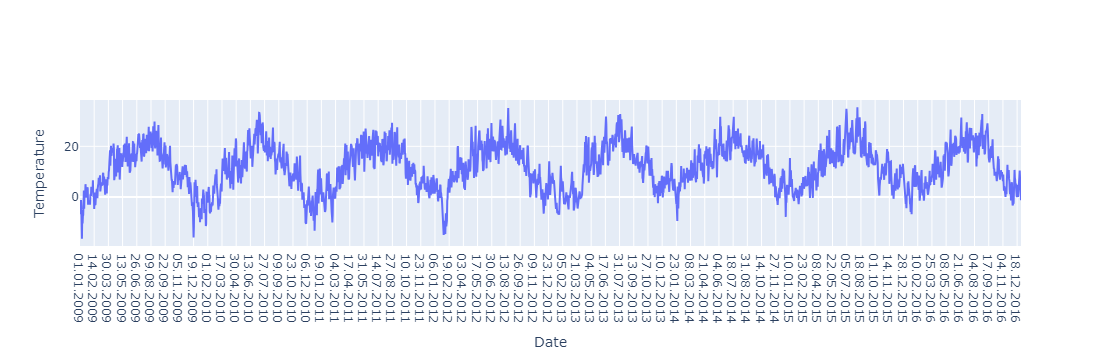

In [48]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=df.index, y=df["T (degC)"]))
fig.update_layout(
    xaxis_title = "Date",
    yaxis_title = "Temperature",
)
fig.show()

In [49]:
train = 0
val = int(df.shape[0] * 0.70)
test = int(df.shape[0] * 0.85)

df_train = df.iloc[train : val]
df_val = df.iloc[val : test]
df_test = df.iloc[test : ]

x_train = df_train.drop("target", axis=1)
x_val = df_val.drop("target", axis=1)
x_test = df_test.drop("target", axis=1)

y_train = df_train["target"]
y_val = df_val["target"]
y_test = df_test["target"]

print("Train size: ", x_train.shape, y_train.shape)
print("Validation size: ", x_val.shape, y_val.shape)
print("Test size: ", x_test.shape, y_test.shape)

Train size:  (2043, 14) (2043,)
Validation size:  (439, 14) (439,)
Test size:  (438, 14) (438,)


1. Since we are building deep neural network we need to have **train**, **val** and **test**. Here I define the training set start from index **0**. The Validation set start at **70%** of the dataframe's length. The test set start at **85%88 of the dataframe's length.

2. The code divides the dataframe into into three subsets: the **df_train** consists of rows from the start to **70%** of the dataframe, the validation set **df_val** includes rows from **70%** to **85%**, and the **df_test** contains rows from **85%** to the end.

3. Here we Keep Features Apart from Target: Make sure that the variables **x_train**, **x_val**, and **x_test** just contain the input features; the target variable, which is used to make predictions, is left out.

# FEATURE ENGINEERING

In [50]:
scaler = StandardScaler()
x_train=scaler.fit_transform(x_train)
x_val=scaler.fit_transform(x_val)
x_test = scaler.transform(x_test)

**Functionality:**

**Fit:** Calculates the mean and standard deviation of the features in the dataset.

**Transform:** Uses the calculated mean and standard deviation to scale the features.

# MODEL TRAINING / CREATING SEQUENCE 

In [51]:
Seq_len = 10
batch = 250
input_shape = (Seq_len, x_train.shape[1])

1.  We have set **Seq_len** to 10, signifying that our model will treat the past 10 days of data as a single sequence of input data.

2.  This **batch = 200** parameter determines the number of samples processed by the model at once, effectively balancing memory usage and ensuring a fast and stable training process.

3.  Specify the shape of the input data for the model, with 10 time steps and the number of features in **x_train**.

In [52]:
dataset_train = tf.keras.preprocessing.timeseries_dataset_from_array(
    x_train,
    y_train,
    sequence_length = Seq_len,
    batch_size = batch,
)

dataset_validation = tf.keras.preprocessing.timeseries_dataset_from_array(
    x_val,
    y_val,
    sequence_length = Seq_len,
    batch_size = batch,
)

dataset_test = tf.keras.preprocessing.timeseries_dataset_from_array(
    x_test,
    y_test,
    sequence_length = Seq_len,
    batch_size = batch,
)

We are creating time series datasets for training, validation and testing using **TensorFlow's** library using **timeseries_dataset_from_array** function

# MODEL BUILDING 

In [63]:
model = Sequential([
    Input(shape=input_shape),
    LSTM(32),
    BatchNormalization(),
    Dense(1)
])

model.summary() 

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 32)                6016      
                                                                 
 batch_normalization (BatchN  (None, 32)               128       
 ormalization)                                                   
                                                                 
 dense_3 (Dense)             (None, 1)                 33        
                                                                 
Total params: 6,177
Trainable params: 6,113
Non-trainable params: 64
_________________________________________________________________


This model is structured to process time series data and predict a single target value based on the input sequences and I use **LSTM** model for time series analysis.

In [87]:
model.compile(optimizer= tf.keras.optimizers.Adam(learning_rate=0.001), loss = 'mean_squared_error')
checkpoint_callback = ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True)
es_callback = EarlyStopping(monitor='val_loss', patience=5)
model.fit(dataset_train, epochs= 200, validation_data=dataset_validation, shuffle=False, callbacks = [es_callback, checkpoint_callback])
model.load_weights('best_model.h5')

Epoch 1/200
9/9 [==============================] - 3s 58ms/step - loss: 13.2754 - val_loss: 9.1207
Epoch 2/200
9/9 [==============================] - 0s 10ms/step - loss: 13.2539 - val_loss: 9.2389
Epoch 3/200
9/9 [==============================] - 0s 11ms/step - loss: 13.5074 - val_loss: 15.5308
Epoch 4/200
9/9 [==============================] - 0s 10ms/step - loss: 12.9250 - val_loss: 11.6012
Epoch 5/200
9/9 [==============================] - 0s 11ms/step - loss: 12.9368 - val_loss: 11.1869
Epoch 6/200
9/9 [==============================] - 0s 11ms/step - loss: 13.0805 - val_loss: 13.2184


1. **Model Compilation:** Compiles the model with the Adam optimizer and a learning rate of 0.001, using mean squared error as the loss function for regression tasks.

2. **Early Stopping Callback:** Sets up an early stopping mechanism that monitors validation loss (val_loss). If the loss doesn’t improve for 5 consecutive epochs (patience), training will stop to prevent overfitting.

3.  **Model Fitting:** Trains the model using the training dataset for up to 300 epochs, validating on the validation dataset. The training process does not shuffle the data, maintaining the sequential order, and utilizes the early stopping callback to monitor performance. 

# MODEL EVAUATION

In [88]:
actual = np.concatenate([y.numpy() for _, y in dataset_test])
predicted = np.concatenate([model.predict(x).flatten() for x, _ in dataset_test])

r2 = sklearn.metrics.r2_score(actual, predicted)
print("R2 Score:", r2)

6/6 [==============================] - 0s 1ms/step
R2 Score: 0.8793680172538957


1. **Concatenate Actual Values:** Combines the true target values from the test dataset into a single array by iterating through the dataset and extracting y values.

2. **Predict Values:** Generates predictions from the model for the test dataset by iterating through the dataset and flattening the output to create a one-dimensional array of predictions.

3. **Calculate R² Score:** Computes the R² score (coefficient of determination) using the actual and predicted values, which indicates how well the model's predictions match the true values.

# PREDICTION 

In [89]:
# Assuming new_data is a DataFrame with the same structure as df
new_data = pd.DataFrame({
    "p (mbar)": np.random.normal(loc=1000, scale=5, size=10),
    "T (degC)": np.random.normal(loc=10, scale=3, size=10),
    "Tpot (K)": np.random.normal(loc=280, scale=3, size=10),
    "Tdew (degC)": np.random.normal(loc=5, scale=2, size=10),
    "rh (%)": np.random.normal(loc=80, scale=10, size=10),
    "VPmax (mbar)": np.random.normal(loc=10, scale=1, size=10),
    "VPact (mbar)": np.random.normal(loc=8, scale=1, size=10),
    "VPdef (mbar)": np.random.normal(loc=2, scale=0.5, size=10),
    "sh (g/kg)": np.random.normal(loc=5, scale=1, size=10),
    "H2OC (mmol/mol)": np.random.normal(loc=5, scale=1, size=10),
    "rho (g/m**3)": np.random.normal(loc=1.2, scale=0.05, size=10),
    "wv (m/s)": np.random.normal(loc=2, scale=0.5, size=10),
    "max. wv (m/s)": np.random.normal(loc=3, scale=1, size=10),
    "wd (deg)": np.random.normal(loc=180, scale=50, size=10),
})

# Standardizing the new data
new_data_scaled = scaler.transform(new_data)

# Creating sequences from the new data
Seq_len = 10  # as per the training sequence length
new_sequences = [new_data_scaled[i:i + Seq_len] for i in range(len(new_data_scaled) - Seq_len + 1)]
new_sequences = np.array(new_sequences)

# Making predictions
predictions = model.predict(new_sequences)

# Output the predictions
print("Predicted Temperatures:", predictions.flatten())


1/1 [==============================] - 0s 324ms/step
Predicted Temperatures: [-5.3291907]


# CONCLUSION

The development of a deep learning model for predicting daily noon temperatures has demonstrated significant potential for enhancing energy management systems in industrial and commercial settings. By leveraging historical weather data and advanced time-series analysis techniques, the model offers precise and reliable temperature forecasts, which are instrumental in optimizing HVAC operations.

## Key Achievements:

1.**Accurate Forecasting:** The model achieved a high R² score, indicating its robustness and reliability in predicting temperature variations.

2.**Operational Efficiency:** Businesses can now proactively adjust their HVAC systems, leading to more efficient energy use and reduced operational costs.

3.**Sustainability:** Improved energy management supports environmental sustainability by minimizing the carbon footprint.

4.**Enhanced Comfort and Safety:** Accurate temperature predictions help maintain optimal indoor environments, enhancing the comfort and safety of employees and customers.